# Exercise

In this exercise, we will gain some hands-on experience with overfitting and cross-validation in machine learning. We will see how increasing model complexity leads to reduced errors on the training set but a lack of generalizability on unseen data.

Below, you will find code that creates some training data (`X_train` and `y_train`). I'm providing you with the `LinearPolyRegression` class that uses the same `fit(X, y)` and `predict(X)` syntax as all other classes in `scikit-learn` to perform polynomial regression. Its only hyperparameter is the polynomial degree $p$. Finally, I'm also providing the true relation between $x$ and $y$ via the function `f(X)`.

For cross-validation scoring, we will use the negative root mean square error (RMSE), $-\sqrt{\sum (y_i - \hat y)^2 / n}$ instead of the $R^2$ score since the latter is noisy or ill-defined with small validation data sets. The cross-validation procedure is leave-one-out cross-validation. We will determine cross-validation scores for $p=1$, $2$ etc. up to $p=20$.

(a) Determine the cross-validation scores using `sklearn.cross_validate.KFold`.

(b) Determine the cross-validation scores using `sklearn.cross_validate.cross_val_score`. (Hint: To use -RMSE as the score, you can specify `scoring='neg_root_mean_squared_error'`.)

(c) Determine the cross-validation scores using `sklearn.cross_validate.GridSearchCV`.

(d) What do the results indicate? What is the optimal value for $p$?

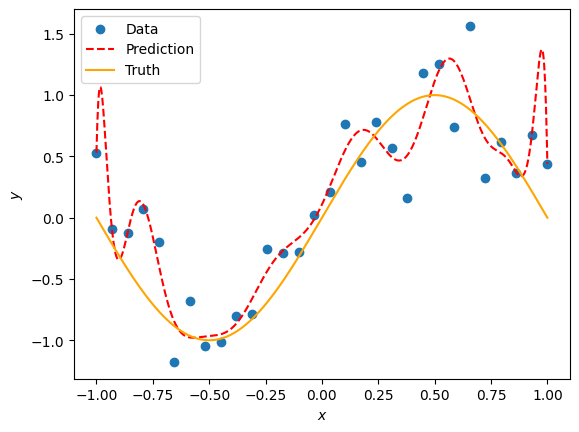

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV


def f(X):
    return np.sin(X[:, 0] * np.pi)

class LinearPolyRegression(BaseEstimator, RegressorMixin):

    def __init__(self, p=1):
        self.p = p

    def fit(self, X, y):
        X = np.column_stack([
            np.ones(len(X))] + [X**i for i in range(1, self.p + 1)])
        self.beta = np.linalg.lstsq(X, y)[0]
        return self

    def predict(self, X):
        X = np.column_stack([
            np.ones(len(X))] + [X**i for i in range(1, self.p + 1)])
        return X @ self.beta

np.random.seed(0)
X_train = np.linspace(-1, +1, 30).reshape(-1, 1)
y_train = f(X_train) + np.random.normal(size=len(X_train)) * 0.3

plt.scatter(X_train[:, 0], y_train, label='Data')
reg = LinearPolyRegression(p=16).fit(X_train, y_train)
X = np.linspace(-1, +1, 1000).reshape(-1, 1)
y_pred = reg.predict(X)
plt.plot(X[:, 0], y_pred, color='red', ls='--', label='Prediction')
plt.plot(X[:, 0], f(X), color='orange', ls='-', label='Truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(loc='best')

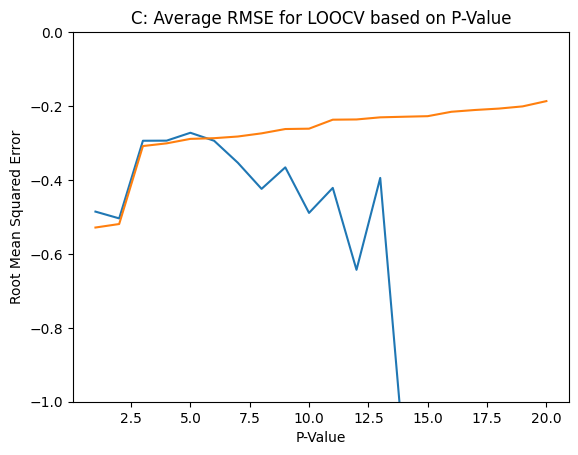

In [5]:
from sklearn import model_selection as model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error


def f(X):
    return np.sin(X[:, 0] * np.pi)

class LinearPolyRegression(BaseEstimator, RegressorMixin):

    def __init__(self, p=1):
        self.p = p

    def fit(self, X, y):
        X = np.column_stack([
            np.ones(len(X))] + [X**i for i in range(1, self.p + 1)])
        self.beta = np.linalg.lstsq(X, y)[0]
        return self

    def predict(self, X):
        X = np.column_stack([
            np.ones(len(X))] + [X**i for i in range(1, self.p + 1)])
        return X @ self.beta

DATA_SIZE = 30
np.random.seed(0)
X_train = np.linspace(-1, +1, DATA_SIZE).reshape(-1, 1)
y_train = f(X_train) + np.random.normal(size=len(X_train)) * 0.3

# true X
X_test = np.linspace(-1, +1, 1000).reshape(-1, 1)
#y_pred_test = reg.predict(X)


def a():
    avg_rmse_list = []
    for p in range(1, 21):
        kf = model.KFold(DATA_SIZE)
        rmse_list = []
        for i, (train_index, test_index) in enumerate(kf.split(X_train)):
            reg = LinearPolyRegression(p=p).fit(X_train[train_index], y_train[train_index])
            y_pred_train = reg.predict(X_train[test_index])
            rmse = root_mean_squared_error(y_pred_train, y_train[test_index])
            rmse_list.append(0 - rmse)

        avg_rmse_list.append(np.mean(rmse_list))

    plt.plot(avg_rmse_list)
    plt.xticks(np.arange(1, 21, 2))
    plt.xlabel("P-Value")
    plt.ylabel("Root Mean Squared Error")
    plt.title("A: Average RMSE for LOOCV based on P-Value")
    plt.show()


def b():
    avg_rmse_list = []
    for p in range(1, 21):
        kf = model.KFold(DATA_SIZE)
        rmse_list = []
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            reg = LinearPolyRegression(p=p).fit(X_train[train_index], y_train[train_index])
            score = model.cross_val_score(reg, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
            rmse_list.append(score)

        avg_rmse_list.append(np.mean(rmse_list))

    plt.plot(avg_rmse_list)
    plt.xticks(np.arange(1, 21, 2))
    plt.xlabel("P-Value")
    plt.ylabel("Root Mean Squared Error")
    plt.title("B: Average RMSE for LOOCV based on P-Value")
    plt.show()

def c():
    p_all = np.arange(1, 21)
    kf = model.KFold(n_splits=DATA_SIZE, shuffle=True)
    reg = model.GridSearchCV(LinearPolyRegression(), dict(p=p_all), cv = kf, scoring='neg_root_mean_squared_error', return_train_score=True).fit(X_train, y_train)
    nrmse_cv_c = reg.cv_results_['mean_test_score']
    nrmse_train_c = reg.cv_results_['mean_train_score']

    plt.plot(p_all, nrmse_cv_c)
    plt.plot(p_all, nrmse_train_c)
    plt.ylim(-1, 0)
    plt.xlabel("P-Value")
    plt.ylabel("Root Mean Squared Error")
    plt.title("C: Average RMSE for LOOCV based on P-Value")
    plt.show()


c()